In [ ]:
!pip install -U transformers huggingface_hub
!pip install datasets huggingface_hub

In [ ]:
import pandas as pd
import numpy as np
import re
import string
import numpy as np
import gc
import matplotlib.pyplot as plt
import seaborn as sns

from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, AutoConfig, EarlyStoppingCallback
import torch

from datasets import load_dataset
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score, f1_score, precision_score, recall_score


In [ ]:
# !unzip /content/drive/MyDrive/DATASET/model_training_dataset.csv

In [ ]:
#from huggingface_hub import notebook_login
#notebook_login()

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/DATASET/wiki-labeled.csv")
df.head()

,title,label,text,word_count
0,James Scobie,0,James Scobie (29 November 1826 – 7 October 185...,175
1,James Scobie,1,James Scobie (29 November 1826 – 7 October 189...,242
2,Dagliç sheep,0,The Dagliç is a breed of sheep found primarily...,152
3,Dagliç sheep,1,The Dagliç is a breed of sheep that is found i...,33
4,Hamdard India,0,"Hamdard Laboratories (India), is a Unani pharm...",160


In [ ]:
#df = df[["human_text","ai_text"]]
#print (df.head())

In [ ]:
def clean_text(text):
    text = str(text).strip()
    text = re.sub(r"\s+", " ", text)
    return text

df["clean_text"] = df["text"].apply(clean_text)

In [ ]:
df = df.drop_duplicates(subset=["clean_text"]).reset_index(drop=True)

In [ ]:
human_sample = df[df["label"] == 0].sample(n=50000, random_state=42)
ai_sample = df[df["label"] == 1].sample(n=50000, random_state=42)

sampled_df = pd.concat([human_sample, ai_sample], ignore_index=True)
sampled_df = sampled_df.sample(frac=1, random_state=42).reset_index(drop=True)

print(sampled_df["label"].value_counts())

label
1    50000
0    50000
Name: count, dtype: int64


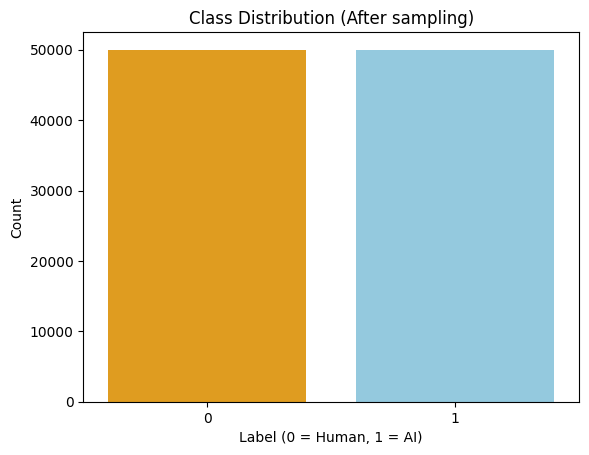

In [ ]:
palette_dict = {0: 'orange', 1: 'skyblue'}
sns.countplot(x='label', hue='label', data=sampled_df, palette=palette_dict, dodge=False, legend=False)
plt.title('Class Distribution (After sampling)')
plt.xlabel('Label (0 = Human, 1 = AI)')
plt.ylabel('Count')
plt.show()

In [ ]:
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    sampled_df['clean_text'].tolist(),
    sampled_df['label'].tolist(),
    test_size=0.3,
    stratify=sampled_df['label'],
    random_state=42
)

val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts,
    temp_labels,
    test_size=0.5,
    stratify=temp_labels,
    random_state=42
)

In [ ]:
overlap_train_val = len(set(train_texts) & set(val_texts))
overlap_train_test = len(set(train_texts) & set(test_texts))
overlap_val_test = len(set(val_texts) & set(test_texts))

print("Overlap Check")
print("Train ↔ Val :", overlap_train_val)
print("Train ↔ Test:", overlap_train_test)
print("Val   ↔ Test:", overlap_val_test, "\n")

Overlap Check
Train ↔ Val : 0
Train ↔ Test: 0
Val   ↔ Test: 0 



BERT

In [ ]:
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

#coba cek rata rata panjang token
lengths = [len(tokenizer.encode(t)) for t in sampled_df['clean_text'].tolist()]
print(np.percentile(lengths, [50, 75, 90, 95, 99]))

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (594 > 512). Running this sequence through the model will result in indexing errors


[218. 269. 310. 348. 433.]


In [ ]:
def batch_tokenize(texts, batch_size=500):
    all_encodings = {"input_ids": [], "attention_mask": []}
    for i in tqdm(range(0, len(texts), batch_size)):
        batch = texts[i:i+batch_size]
        enc = tokenizer(batch, truncation=True, padding="max_length", max_length=512, return_tensors='pt')
        all_encodings["input_ids"].append(enc["input_ids"])
        all_encodings["attention_mask"].append(enc["attention_mask"])
        del enc, batch
        gc.collect()
    all_encodings["input_ids"] = torch.cat(all_encodings["input_ids"])
    all_encodings["attention_mask"] = torch.cat(all_encodings["attention_mask"])
    return all_encodings

train_enc = batch_tokenize(train_texts)
val_enc = batch_tokenize(val_texts)
test_enc = batch_tokenize(test_texts)

100%|██████████| 30/30 [00:21<00:00,  1.39it/s]


In [ ]:
class TextDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

In [ ]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average="weighted"),
        "precision": precision_score(labels, preds, average="weighted"),
        "recall": recall_score(labels, preds, average="weighted")
    }

In [ ]:
train_dataset = TextDataset(train_enc, train_labels)
val_dataset = TextDataset(val_enc, val_labels)
test_dataset = TextDataset(test_enc, test_labels)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2
)
model.to(device)
model.eval()

def predict_batch(texts, batch_size=500):
    preds = []
    for i in tqdm(range(0, len(texts), batch_size)):
        batch = texts[i:i+batch_size]
        enc = tokenizer(batch, truncation=True, padding="max_length", max_length=512, return_tensors='pt')
        enc = {k: v.to(device) for k, v in enc.items()}

        with torch.no_grad():
            outputs = model(**enc)
        preds.extend(torch.argmax(outputs.logits, dim=-1).cpu().numpy())
    return np.array(preds)

preds = predict_batch(val_texts)
labels = np.array(val_labels)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 30/30 [07:12<00:00, 14.42s/it]


100%|██████████| 30/30 [07:18<00:00, 14.63s/it]

Accuracy:  0.4862
F1-score:  0.3783
Precision: 0.4549
Recall:    0.4862


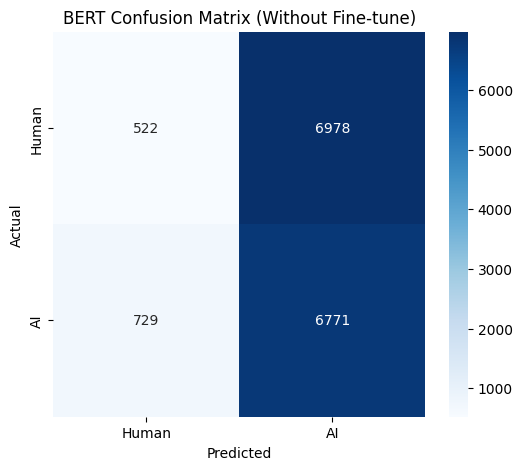


Classification Report:
              precision    recall  f1-score   support

       Human       0.42      0.07      0.12      7500
          AI       0.49      0.90      0.64      7500

    accuracy                           0.49     15000
   macro avg       0.45      0.49      0.38     15000
weighted avg       0.45      0.49      0.38     15000



In [ ]:
# Prediction
bert_preds = predict_batch(val_texts)
val_labels_np = np.array(val_labels)

# Evaluation
acc = accuracy_score(val_labels_np, bert_preds)
f1 = f1_score(val_labels_np, bert_preds, average="weighted")
precision = precision_score(val_labels_np, bert_preds, average="weighted")
recall = recall_score(val_labels_np, bert_preds, average="weighted")

print(f"Accuracy:  {acc:.4f}")
print(f"F1-score:  {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")

# Confusion Matrix
labels = [0, 1]
label_names = ['Human', 'AI']
cm = confusion_matrix(val_labels_np, bert_preds, labels=labels)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_names, yticklabels=label_names)
plt.title('BERT Confusion Matrix (Without Fine-tune)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(val_labels_np, bert_preds, target_names=label_names))


In [ ]:
config = AutoConfig.from_pretrained(
    model_name,
    num_labels=2,
    hidden_dropout_prob=0.1,              # dropout layer hidden
    attention_probs_dropout_prob=0.1      # dropout attention
)

model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    config=config
)

print("Model loaded successfully:", model_name)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded successfully: bert-base-uncased


In [ ]:
training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=1e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=2,
    num_train_epochs=2,
    weight_decay=0.01,
    warmup_ratio=0.1,
    eval_strategy="steps",
    eval_steps=1000,
    logging_steps=1000,
    save_strategy="steps",
    save_steps=1000,
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    fp16=True,
    logging_dir="./logs",
    report_to="none",
    disable_tqdm=False,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.evaluate()
trainer.train()

/tmp/ipython-input-2427156306.py:25: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/tmp/ipython-input-3248684799.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}


/tmp/ipython-input-3248684799.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}


Step,Training Loss,Validation Loss,Model Preparation Time,Accuracy,F1,Precision,Recall
1000,0.253000,0.432942,0.003000,0.916000,0.915409,0.927964,0.916000
2000,0.048000,0.341662,0.003000,0.932400,0.932091,0.940419,0.932400
3000,0.030800,0.144233,0.003000,0.970467,0.970441,0.972099,0.970467
4000,0.026400,0.329647,0.003000,0.934000,0.933712,0.941665,0.934000
5000,0.016700,0.106238,0.003000,0.981400,0.981394,0.982029,0.981400
6000,0.013400,0.212120,0.003000,0.965533,0.965493,0.967722,0.965533
7000,0.008700,0.114434,0.003000,0.980533,0.980526,0.981243,0.980533
8000,0.005000,0.193785,0.003000,0.969533,0.969505,0.971268,0.969533


/tmp/ipython-input-3248684799.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
/tmp/ipython-input-3248684799.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
/tmp/ipython-input-3248684799.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
/tmp/ipython-input-3248684799.py:10: UserWarning: To copy construct from a tensor, it is re

TrainOutput(global_step=8750, training_loss=0.04652936199733189, metrics={'train_runtime': 4374.9392, 'train_samples_per_second': 32.0, 'train_steps_per_second': 2.0, 'total_flos': 3.68355477504e+16, 'train_loss': 0.04652936199733189, 'epoch': 2.0})

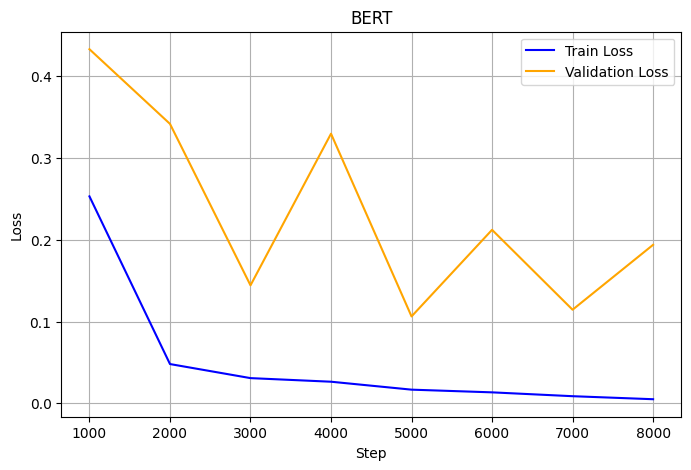

In [ ]:
log_history = pd.DataFrame(trainer.state.log_history)

train_loss = log_history[log_history["loss"].notna()][["step", "loss"]].copy()
eval_loss = log_history[log_history["eval_loss"].notna()][["step", "eval_loss"]].copy()

plt.figure(figsize=(8,5))
plt.plot(train_loss["step"], train_loss["loss"], label="Train Loss", color="blue")
plt.plot(eval_loss["step"], eval_loss["eval_loss"], label="Validation Loss", color="orange")

plt.title("BERT")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

/tmp/ipython-input-3248684799.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}


Accuracy:  0.9814
F1-score:  0.9814
Precision: 0.9820
Recall:    0.9814


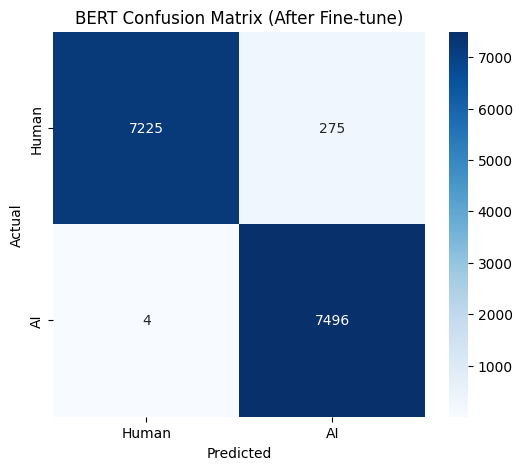


Classification Report:
              precision    recall  f1-score   support

       Human       1.00      0.96      0.98      7500
          AI       0.96      1.00      0.98      7500

    accuracy                           0.98     15000
   macro avg       0.98      0.98      0.98     15000
weighted avg       0.98      0.98      0.98     15000



In [ ]:
# prediction
pred_output = trainer.predict(val_dataset)
bert_preds = pred_output.predictions.argmax(-1)

# convert label
val_labels_np = np.array(val_labels)

# metrics
acc = accuracy_score(val_labels_np, bert_preds)
f1 = f1_score(val_labels_np, bert_preds, average="weighted")
precision = precision_score(val_labels_np, bert_preds, average="weighted")
recall = recall_score(val_labels_np, bert_preds, average="weighted")

print(f"Accuracy:  {acc:.4f}")
print(f"F1-score:  {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")

# confusion matrix
labels = [0, 1]
label_names = ['Human', 'AI']
cm = confusion_matrix(val_labels_np, bert_preds, labels=labels)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_names, yticklabels=label_names)
plt.title('BERT Confusion Matrix (After Fine-tune)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# --- Classification Report ---
print("\nClassification Report:")
print(classification_report(val_labels_np, bert_preds, target_names=label_names))

/tmp/ipython-input-3248684799.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}


 BERT TEST RESULTS (After Fine-Tune)
Accuracy:  0.9807
F1-score:  0.9807
Precision: 0.9814
Recall:    0.9807


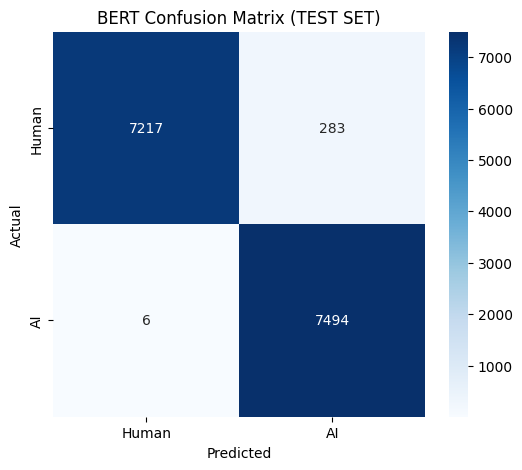


TEST Classification Report:
              precision    recall  f1-score   support

       Human       1.00      0.96      0.98      7500
          AI       0.96      1.00      0.98      7500

    accuracy                           0.98     15000
   macro avg       0.98      0.98      0.98     15000
weighted avg       0.98      0.98      0.98     15000



In [ ]:
#Prediction on TEST dataset
test_output = trainer.predict(test_dataset)
test_preds = test_output.predictions.argmax(-1)


test_labels_np = np.array(test_labels)

# Metrics
acc = accuracy_score(test_labels_np, test_preds)
f1 = f1_score(test_labels_np, test_preds, average="weighted")
precision = precision_score(test_labels_np, test_preds, average="weighted")
recall = recall_score(test_labels_np, test_preds, average="weighted")

print(" BERT TEST RESULTS (After Fine-Tune)")
print(f"Accuracy:  {acc:.4f}")
print(f"F1-score:  {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")

#Confusion Matrix (TEST)
labels = [0, 1]
label_names = ['Human', 'AI']
cm = confusion_matrix(test_labels_np, test_preds, labels=labels)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_names, yticklabels=label_names)
plt.title('BERT Confusion Matrix (TEST SET)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Classification Report
print("\nTEST Classification Report:")
print(classification_report(test_labels_np, test_preds,
                            target_names=label_names))

ROBERTA

In [ ]:
del model
if 'model' in locals():
    del model
torch.cuda.empty_cache()
gc.collect()

9175

In [ ]:
model_name = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
print("Tokenizer loaded:", model_name)

lengths = [len(tokenizer.encode(t)) for t in sampled_df['clean_text'].tolist()]
print(np.percentile(lengths, [50, 75, 90, 95, 99]))

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (603 > 512). Running this sequence through the model will result in indexing errors


Tokenizer loaded: roberta-base
[222. 275. 313. 355. 446.]


In [ ]:
def batch_tokenize(texts, batch_size=500):
    all_encodings = {"input_ids": [], "attention_mask": []}

    for i in tqdm(range(0, len(texts), batch_size)):
        batch = texts[i:i+batch_size]
        enc = tokenizer(
            batch,
            truncation=True,
            padding="max_length",
            max_length=512,
            return_tensors='pt'
        )
        all_encodings["input_ids"].append(enc["input_ids"])
        all_encodings["attention_mask"].append(enc["attention_mask"])
        del enc, batch
        gc.collect()

    all_encodings["input_ids"] = torch.cat(all_encodings["input_ids"])
    all_encodings["attention_mask"] = torch.cat(all_encodings["attention_mask"])
    return all_encodings

train_enc = batch_tokenize(train_texts)
val_enc = batch_tokenize(val_texts)
test_enc = batch_tokenize(test_texts)

100%|██████████| 30/30 [00:18<00:00,  1.65it/s]


In [ ]:
class TextDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item


In [ ]:
train_dataset = TextDataset(train_enc, train_labels)
val_dataset = TextDataset(val_enc, val_labels)
test_dataset = TextDataset(test_enc, test_labels)

In [ ]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average="weighted"),
        "precision": precision_score(labels, preds, average="weighted"),
        "recall": recall_score(labels, preds, average="weighted")
    }

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2
)
model.to(device)
model.eval()

def predict_batch(texts, batch_size=500):
    preds = []
    for i in tqdm(range(0, len(texts), batch_size)):
        batch = texts[i:i+batch_size]
        enc = tokenizer(batch, truncation=True, padding="max_length", max_length=512, return_tensors='pt')
        enc = {k: v.to(device) for k, v in enc.items()}

        with torch.no_grad():
            outputs = model(**enc)

        preds.extend(torch.argmax(outputs.logits, dim=-1).cpu().numpy())
    return np.array(preds)

roberta_before = predict_batch(val_texts)

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 30/30 [06:32<00:00, 13.07s/it]


100%|██████████| 30/30 [06:35<00:00, 13.20s/it]

Accuracy:  0.5000
F1-score:  0.3333
Precision: 0.2500
Recall:    0.5000



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


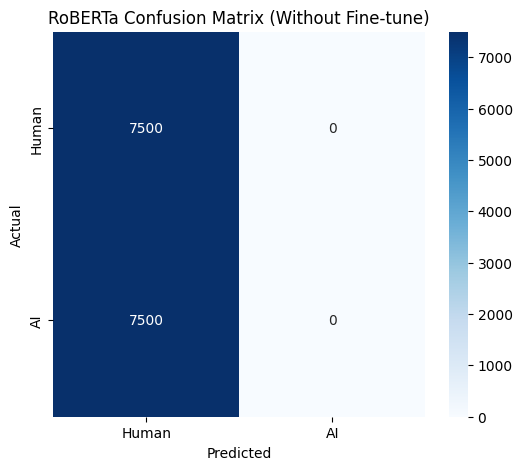


Classification Report:
              precision    recall  f1-score   support

       Human       0.50      1.00      0.67      7500
          AI       0.00      0.00      0.00      7500

    accuracy                           0.50     15000
   macro avg       0.25      0.50      0.33     15000
weighted avg       0.25      0.50      0.33     15000



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# Prediction
roberta_preds_before = predict_batch(val_texts)
val_labels_np = np.array(val_labels)

# Evaluation
acc = accuracy_score(val_labels_np, roberta_preds_before)
f1 = f1_score(val_labels_np, roberta_preds_before, average="weighted")
precision = precision_score(val_labels_np, roberta_preds_before, average="weighted")
recall = recall_score(val_labels_np, roberta_preds_before, average="weighted")

print(f"Accuracy:  {acc:.4f}")
print(f"F1-score:  {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")

# Confusion Matrix
labels = [0, 1]
label_names = ['Human', 'AI']
cm = confusion_matrix(val_labels_np, roberta_preds_before, labels=labels)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_names, yticklabels=label_names)
plt.title('RoBERTa Confusion Matrix (Without Fine-tune)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(val_labels_np, roberta_preds_before, target_names=label_names))

In [ ]:
config = AutoConfig.from_pretrained(
    model_name,
    num_labels=2,
    hidden_dropout_prob=0.1,
    attention_probs_dropout_prob=0.1
)

model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    config=config
)

print("RoBERTa Model loaded:", model_name)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RoBERTa Model loaded: roberta-base


In [ ]:
training_args = TrainingArguments(
    output_dir="./results_roberta",
    learning_rate=1e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=2,
    num_train_epochs=2,
    weight_decay=0.01,
    warmup_ratio=0.1,
    eval_strategy="steps",
    eval_steps=1000,
    logging_steps=1000,
    save_strategy="steps",
    save_steps=1000,
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    fp16=True,
    report_to="none",
    disable_tqdm=False,
)


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()
trainer.evaluate()

/tmp/ipython-input-1107481468.py:25: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/tmp/ipython-input-2076376317.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1000,0.243900,0.133521,0.977467,0.977456,0.978337,0.977467
2000,0.065700,0.131243,0.980000,0.979993,0.980699,0.980000
3000,0.042200,0.085543,0.979600,0.979592,0.980389,0.979600
4000,0.031300,0.092903,0.984200,0.984196,0.984676,0.984200
5000,0.020900,0.162589,0.977867,0.977856,0.978782,0.977867
6000,0.015800,0.214819,0.967467,0.967432,0.969438,0.967467
7000,0.011300,0.159982,0.978400,0.978390,0.979283,0.978400
8000,0.008300,0.124481,0.983667,0.983662,0.984175,0.983667


/tmp/ipython-input-2076376317.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
/tmp/ipython-input-2076376317.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
/tmp/ipython-input-2076376317.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
/tmp/ipython-input-2076376317.py:10: UserWarning: To copy construct from a tensor, it is re

Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1000,0.243900,0.133521,0.977467,0.977456,0.978337,0.977467
2000,0.065700,0.131243,0.980000,0.979993,0.980699,0.980000
3000,0.042200,0.085543,0.979600,0.979592,0.980389,0.979600
4000,0.031300,0.092903,0.984200,0.984196,0.984676,0.984200
5000,0.020900,0.162589,0.977867,0.977856,0.978782,0.977867
6000,0.015800,0.214819,0.967467,0.967432,0.969438,0.967467
7000,0.011300,0.159982,0.978400,0.978390,0.979283,0.978400
8000,0.008300,0.124481,0.983667,0.983662,0.984175,0.983667


/tmp/ipython-input-2076376317.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}


{'eval_loss': 0.09290316700935364,
 'eval_accuracy': 0.9842,
 'eval_f1': 0.9841961210257051,
 'eval_precision': 0.9846758439730384,
 'eval_recall': 0.9842,
 'eval_runtime': 105.1728,
 'eval_samples_per_second': 142.622,
 'eval_steps_per_second': 17.828,
 'epoch': 2.0}

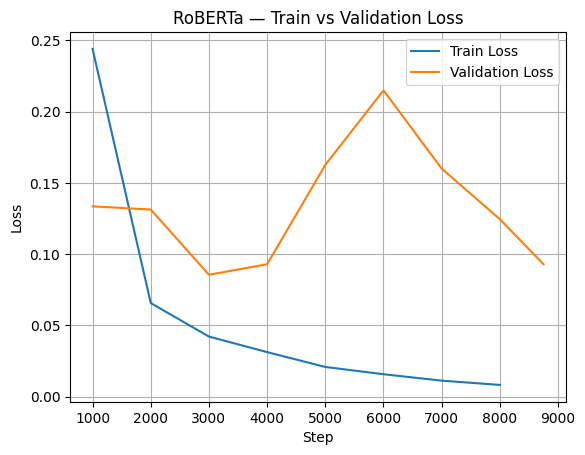

In [ ]:
log_history = pd.DataFrame(trainer.state.log_history)
train_loss = log_history[log_history["loss"].notna()][["step", "loss"]]
eval_loss = log_history[log_history["eval_loss"].notna()][["step", "eval_loss"]]

plt.plot(train_loss["step"], train_loss["loss"], label="Train Loss")
plt.plot(eval_loss["step"], eval_loss["eval_loss"], label="Validation Loss")
plt.legend()
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("RoBERTa — Train vs Validation Loss")
plt.grid(True)
plt.show()

/tmp/ipython-input-2076376317.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}


Accuracy:  0.9842
F1-score:  0.9842
Precision: 0.9847
Recall:    0.9842


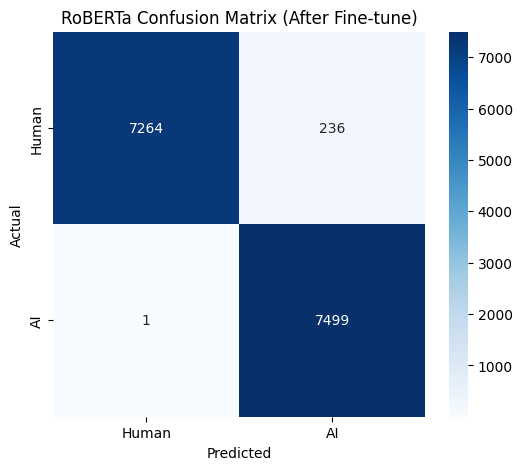


Classification Report:
              precision    recall  f1-score   support

       Human       1.00      0.97      0.98      7500
          AI       0.97      1.00      0.98      7500

    accuracy                           0.98     15000
   macro avg       0.98      0.98      0.98     15000
weighted avg       0.98      0.98      0.98     15000



In [ ]:
# --- Prediction using Trainer ---
pred_output = trainer.predict(val_dataset)
roberta_preds = pred_output.predictions.argmax(-1)

# --- Convert labels ---
val_labels_np = np.array(val_labels)

# --- Metrics ---
acc = accuracy_score(val_labels_np, roberta_preds)
f1 = f1_score(val_labels_np, roberta_preds, average="weighted")
precision = precision_score(val_labels_np, roberta_preds, average="weighted")
recall = recall_score(val_labels_np, roberta_preds, average="weighted")

print(f"Accuracy:  {acc:.4f}")
print(f"F1-score:  {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")

# --- Confusion Matrix ---
labels = [0, 1]
label_names = ['Human', 'AI']
cm = confusion_matrix(val_labels_np, roberta_preds, labels=labels)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_names, yticklabels=label_names)
plt.title('RoBERTa Confusion Matrix (After Fine-tune)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# --- Classification Report ---
print("\nClassification Report:")
print(classification_report(val_labels_np, roberta_preds, target_names=label_names))


/tmp/ipython-input-2076376317.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}


 RoBERTa TEST RESULTS (After Fine-Tune)
Accuracy:  0.9845
F1-score:  0.9845
Precision: 0.9850
Recall:    0.9845


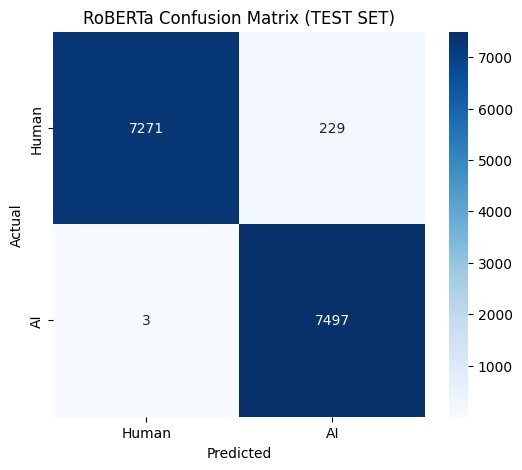


TEST Classification Report:
              precision    recall  f1-score   support

       Human       1.00      0.97      0.98      7500
          AI       0.97      1.00      0.98      7500

    accuracy                           0.98     15000
   macro avg       0.98      0.98      0.98     15000
weighted avg       0.98      0.98      0.98     15000



In [ ]:
# --- Prediction on TEST dataset ---
test_output = trainer.predict(test_dataset)
roberta_test_preds = test_output.predictions.argmax(-1)

# --- Convert to numpy ---
test_labels_np = np.array(test_labels)

# --- Metrics ---
acc = accuracy_score(test_labels_np, roberta_test_preds)
f1 = f1_score(test_labels_np, roberta_test_preds, average="weighted")
precision = precision_score(test_labels_np, roberta_test_preds, average="weighted")
recall = recall_score(test_labels_np, roberta_test_preds, average="weighted")

print(" RoBERTa TEST RESULTS (After Fine-Tune)")
print(f"Accuracy:  {acc:.4f}")
print(f"F1-score:  {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")

# --- Confusion Matrix (TEST) ---
labels = [0, 1]
label_names = ['Human', 'AI']
cm = confusion_matrix(test_labels_np, roberta_test_preds, labels=labels)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_names, yticklabels=label_names)
plt.title('RoBERTa Confusion Matrix (TEST SET)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# --- Classification Report ---
print("\nTEST Classification Report:")
print(classification_report(test_labels_np, roberta_test_preds,
                            target_names=label_names))
